In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
from sklearn import neighbors

# Feature Extraction

Reading the Whole Dataset and dropping the 'useless' data fields, therefore leaving the 3 formants and the Vowel Phoneme

In [82]:
print("Reading the Data...")

data = pd.read_csv("rawdataset.csv")

data = data.drop(['Speaker Label'], axis = 1)
data = data.drop(['Gender'], axis = 1)
data = data.drop(['Word'], axis = 1)
data = data.drop(['Class'], axis = 1)
data = data.drop(['Time Marker'], axis = 1)

print("Dataset...")
print(data)
print("Finished...")

print("Splitting into Gender Datasets...")
gendertest = pd.read_csv("rawdataset.csv")
gendertest = gendertest.drop(['Speaker Label'], axis = 1)
gendertest = gendertest.drop(['Word'], axis = 1)
gendertest = gendertest.drop(['Class'], axis = 1)
gendertest = gendertest.drop(['Time Marker'], axis = 1)

gendertest = gendertest.set_index("Gender")

print("Splitting Female Dataset...")
female = gendertest.drop(["M"], axis = 0)
print("Splitting Male Dataset...")
male = gendertest.drop(["F"], axis = 0)

print("Finished Split...")

print("Female Dataset...")
print(female)
print("Male Dataset...")
print(male)

Reading the Data...
Dataset...
    VowelPhoneme     Formant1     Formant2     Formant3
0             IY   434.936633  2675.424694  3109.763299
1             EH   764.290090  2352.944311  3135.745249
2             UH   669.311088  1480.634263  2795.212672
3             IY   334.539276  2399.227201  2953.039129
4             EH   534.938773  2091.716984  2662.214150
..           ...          ...          ...          ...
145           EH   559.521241  2436.745638  3002.987180
146           UH   420.846534  2039.074500  2756.119879
147           IY   155.105185  2420.387305  3025.554969
148           EH   534.411664  2109.610205  2916.112097
149           UH  1569.345614  2549.187617  3349.469301

[150 rows x 4 columns]
Finished...
Splitting into Gender Datasets...
Splitting Female Dataset...
Splitting Male Dataset...
Finished Split...
Female Dataset...
       VowelPhoneme    Formant1     Formant2     Formant3
Gender                                                   
F                IY  

# Modelling the Data

## Splitting into Test and Training Sets

The 'VowelPhoneme' is either dropped or chosen in the respective training and test sets is due to the Vowel Phoneme being the label, and therefore X is trained and tested without the label, whereas y is training and testing only the phonemes

In [77]:
train, test = train_test_split(female, test_size= 0.25, shuffle=True)

y_train = train.VowelPhoneme
X_train = train.drop(['VowelPhoneme'], axis=1)
y_test = test.VowelPhoneme
X_test = test.drop(['VowelPhoneme'], axis=1)

## Allowing the Plotting of a Confusion Matrix

The function below upon calling prints the confusion matrix given a classification algorithm being executed correctly

In [61]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

## Allowing the Model to be Performed
With additional helping prints

In [62]:
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, print_cm=True, cm_map=plt.cm.Greens):
    # to store results at various phases
    results = dict()
    
    # time at which model starts training
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print("Done\n\n")
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done\n\n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing_time(HH:MM:SS.ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
    
    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('-----------------------')
    print('|       Accuracy      |')
    print('-----------------------')
    print('\n      {}\n\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm:
        print('-----------------------')
        print('|   Confusion Matrix  |')
        print('-----------------------')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap=cm_map)
    plt.show()
    
    # get classification report
    print('-----------------------------')
    print('|   Classification Report   |')
    print('-----------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained model to the results
    results['model'] = model
    
    return results

Printing the best parameters after the grid search is performed. This aids in the testing procedure, helping identify which variables are to be fixed or not, and also helps in the analysis, to understand and explain where the classification works best

In [63]:
# function to print the gridsearch Attributes
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('-----------------------')
    print('|    Best Estimator   |')
    print('-----------------------')
    print('\n\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while performing grid search
    print('-----------------------')
    print('|   Best Parameters   |')
    print('-----------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))
    
    # number of cross validation splits
    print('--------------------------------')
    print('|  No of CrossValidation sets  |')
    print('--------------------------------')
    print('\n\tTotal number of cross validation sets: {}\n'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('-----------------------')
    print('|      Best Score     |')
    print('-----------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))

## K Nearest Neighbours



training the model..
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Done


training_time(HH:MM:SS.ms) - 0:00:00.650059


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.002965


-----------------------
|       Accuracy      |
-----------------------

      0.8947368421052632


-----------------------
|   Confusion Matrix  |
-----------------------

 [[6 0 0]
 [0 4 0]
 [2 0 7]]


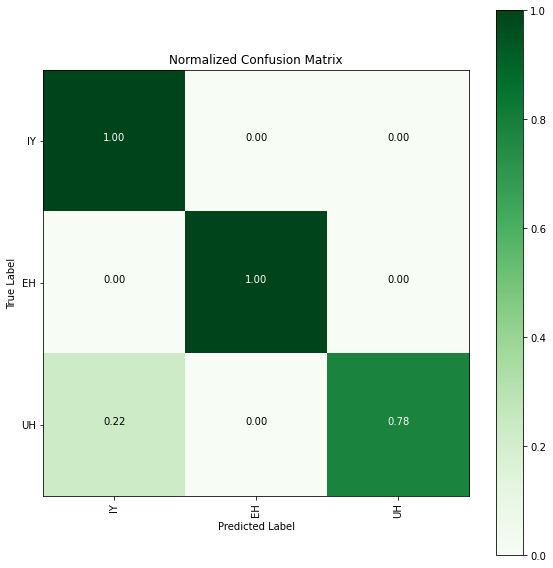

-----------------------------
|   Classification Report   |
-----------------------------
              precision    recall  f1-score   support

          EH       0.75      1.00      0.86         6
          IY       1.00      1.00      1.00         4
          UH       1.00      0.78      0.88         9

    accuracy                           0.89        19
   macro avg       0.92      0.93      0.91        19
weighted avg       0.92      0.89      0.90        19



In [78]:
knn_params = {'n_neighbors':[2, 3, 4, 5], 'weights': ['uniform','distance'], 'algorithm': ['ball_tree', 'kd_tree','brute'], 'metric': ['minkowski']}
labels = ['IY', 'EH', 'UH']
knn_kernel = neighbors.KNeighborsClassifier()
knn_grid = GridSearchCV(knn_kernel, param_grid=knn_params, n_jobs=-1, verbose=1)
knn_grid_results = perform_model(knn_grid, X_train, y_train, X_test, y_test, class_labels = labels)

The below was created to assist in a better KNN Classifier. Initially I had opted for larger values of K, which resulted in an unsatisfying accuracy. The below showed that a value of K being 2 is the best option which sky rocketed the accuracy.

In [37]:
print_grid_search_attributes(knn_grid_results['model'])

-----------------------
|    Best Estimator   |
-----------------------

	KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3)

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}

--------------------------------
|  No of CrossValidation sets  |
--------------------------------

	Total number of cross validation sets: 5

-----------------------
|      Best Score     |
-----------------------

	Average Cross Validate scores of best estimator : 

	0.8928853754940711

